In [1]:
%reset
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.ticker as mticker
import warnings; warnings.filterwarnings('ignore')
import cmocean

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
%cd /glade/p/univ/unyu0004/neerajab/NeverWorld2/
run=20 #1/4 degree NeverWorld2 setup
#run=26 #1/8 degree NeverWorld2 setup
#run=28 #1/16 degree NeverWorld2 setup
fs=xr.open_dataset('run%i/static.nc' % (run), decode_times=False)
os=xr.open_dataset('run%i/ocean.stats.nc' % (run), decode_times=False)
forcing=xr.open_dataset('run%i/forcing_00000500.nc' % (run), decode_times=False)
tau = 500*86400
end_time = 30500
start_time = end_time - tau/86400

sn     = xr.open_dataset('run%i/snapshots_000%i.nc' % (run, end_time-500+5), decode_times=False) #snapshot
av     = xr.open_dataset('run%i/averages_000%i.nc' % (run, end_time-500+2), decode_times=False)  #5-day average
%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/
#print(av)

/glade/p/univ/unyu0004/neerajab/NeverWorld2
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


In [37]:
#For the 1/32 degree run:

%cd /glade/p/univ/unyu0004/neerajab/NeverWorld2/
run=33 #1/32 degree NeverWorld setup
fs=xr.open_dataset('run%i/static.nc' % (run), decode_times=False)
os=xr.open_dataset('run%i/ocean.stats.nc' % (run), decode_times=False)
forcing=xr.open_dataset('run%i/forcing_00002000.nc' % (run), decode_times=False)

av=xr.open_mfdataset(['run33/averages_00001702.nc','run33/averages_00001802.nc', 'run33/averages_00001902.nc', 'run33/averages_00002002.nc', 'run33/averages_00002102.nc'],decode_times=False,combine='by_coords')
print(av)
%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/

/glade/p/univ/unyu0004/neerajab/NeverWorld2
<xarray.Dataset>
Dimensions:     (nv: 2, time: 100, xh: 1920, xq: 1921, yh: 4480, yq: 4481, zi: 16, zl: 15)
Coordinates:
  * zl          (zl) float64 1.023e+03 1.023e+03 ... 1.028e+03 1.028e+03
  * zi          (zi) float64 1.022e+03 1.023e+03 ... 1.028e+03 1.028e+03
  * yh          (yh) float64 -69.98 -69.95 -69.92 -69.89 ... 69.92 69.95 69.98
  * xh          (xh) float64 0.01562 0.04688 0.07812 ... 59.92 59.95 59.98
  * xq          (xq) float64 0.0 0.03125 0.0625 0.09375 ... 59.94 59.97 60.0
  * nv          (nv) float64 1.0 2.0
  * yq          (yq) float64 -70.0 -69.97 -69.94 -69.91 ... 69.94 69.97 70.0
  * time        (time) float64 1.702e+03 1.708e+03 ... 2.192e+03 2.198e+03
Data variables:
    u           (time, zl, yh, xq) float32 dask.array<chunksize=(20, 15, 4480, 1921), meta=np.ndarray>
    v           (time, zl, yq, xh) float32 dask.array<chunksize=(20, 15, 4481, 1920), meta=np.ndarray>
    h           (time, zl, yh, xh) float32 dask

In [103]:
# #DO THE THICKNESS AVERAGING OF VELOCITIES FIRST: this is the original way I was doing it
# Nlayers=15
# lon=fs['geolon']; lat=fs['geolat']
# depth = fs['depth_ocean']
# xh = fs.xh.values
# yh = fs.yh.values

# #Outputs are comprised of 20 5-day averages.
# u  = np.array(av['u'][:,:,:,:]); u = 0.5*(u[:,:,:,1:]+u[:,:,:,:-1]) 
# v  = np.array(av['v'][:,:,:,:]); v = 0.5*(v[:,:,1:,:]+v[:,:,:-1,:]) 
# h  = np.array(av['h'][:,:,:,:]);
# Depth_4D=np.transpose(np.tile(np.nansum(h,axis=1),[Nlayers,1,1,1]),(1,0,2,3))

# #Compute thickness-weighted velocities at each layer
# TW_u = u*h/Depth_4D; TW_v = v*h/Depth_4D;
# #Computing barotropic velocities, as depth-mean, thickness-weighted velocities
# BT_u = np.transpose(np.tile(np.nanmean(TW_u,axis=1),[Nlayers,1,1,1]),(1,0,2,3));
# BT_v = np.transpose(np.tile(np.nanmean(TW_v,axis=1),[Nlayers,1,1,1]),(1,0,2,3));
# # #Baroclinic velocities as difference between thickness weighted raw and BT velocities:
# BC_u = TW_u-BT_u; BC_v = TW_v-BT_v;

# #Total kinetic energy based on thickness-weighted velocity:
# KE_tot = 0.5*(TW_u)**2 + 0.5*(TW_v)**2;
# #Barotropic kinetic energy:
# KE_BT_u = 0.5*(BT_u)**2; KE_BT_v = 0.5*(BT_v)**2; 
# KE_BT_tot = KE_BT_u+KE_BT_v;

# #METHOD 1 for baroclinic KE: 
# KE_BC_tot_1 = KE_tot-KE_BT_tot;
# #METHOD 2 for baroclinic KE:
# KE_BC_tot_2 = 0.5*(BC_u)**2+0.5*(BC_v)**2

# print(KE_tot.shape)
# print(KE_BT_tot.shape)
# print(KE_BC_tot_1.shape)
# print(KE_BC_tot_2.shape)
# print('done')

In [3]:
#COMPUTE KE AND THEN WEIGH BY THICKNESS
Nlayers=15
lon=fs['geolon']; lat=fs['geolat']
depth = fs['depth_ocean']
xh = fs.xh.values
yh = fs.yh.values

h  = np.array(av['h'][:,:,:,:]);
Interface = np.array(os['Interface']); drho=np.diff(Interface)
drhomat=np.transpose(np.tile(drho,[100,len(yh),len(xh),1]),(0,3,1,2)); 
drhodz=drhomat/h
N2=(9.81/1025.)*drhodz
N2[N2>1.e-3] =np.nan 
mask=N2*0.0+1.0

print('done 0')
#Outputs are comprised of 100 5-day averages.
u  = np.array(av['u'][:,:,:,:]); u = 0.5*(u[:,:,:,1:]+u[:,:,:,:-1]); u[np.isnan(u)]=0;
v  = np.array(av['v'][:,:,:,:]); v = 0.5*(v[:,:,1:,:]+v[:,:,:-1,:]); v[np.isnan(v)]=0;
print('done 1')
h[np.isnan(h)]=0.0
#Filtering out places where N2 is large
u  = u*mask; v  = v*mask; h = h*mask
Depth_4D=np.transpose(np.tile(np.nansum(h,axis=1),[Nlayers,1,1,1]),(1,0,2,3))
print('done 2')
#Compute thickness-weighted velocities at each layer
TW_u = u*h/Depth_4D; TW_v = v*h/Depth_4D;
#Computing barotropic velocities, as depth-mean, thickness-weighted velocities
BT_u = np.transpose(np.tile(np.nansum(TW_u,axis=1),[Nlayers,1,1,1]),(1,0,2,3));
BT_v = np.transpose(np.tile(np.nansum(TW_v,axis=1),[Nlayers,1,1,1]),(1,0,2,3));
# #Baroclinic velocities as difference between raw and BT velocities:
BC_u = u-BT_u; BC_v = v-BT_v;

#Total kinetic energy:
KE_tot = (0.5*(u)**2 + 0.5*(v)**2)*h/Depth_4D;
#Barotropic kinetic energy:
KE_BT_tot = (0.5*(BT_u)**2 + 0.5*(BT_v)**2)*h/Depth_4D; 

#METHOD 1 for baroclinic KE: 
KE_BC_tot_1 = (KE_tot-KE_BT_tot);
#METHOD 2 for baroclinic KE:
KE_BC_tot_2 = (0.5*(BC_u)**2+0.5*(BC_v)**2)*h/Depth_4D

print(KE_tot.shape)
print(KE_BT_tot.shape)
print(KE_BC_tot_1.shape)
print(KE_BC_tot_2.shape)
print('done')

done 0
done 1
done 2
(100, 15, 560, 240)
(100, 15, 560, 240)
(100, 15, 560, 240)
(100, 15, 560, 240)
done


In [282]:
# print(np.argwhere(np.isnan(v)).shape)
# print(np.argwhere(np.isnan(u)).shape)
# print(np.argwhere(np.isnan(KE_tot)).shape)
# print(np.argwhere(np.isnan(KE_BT_tot)).shape)

(67458844, 4)
(67458844, 4)
(67458844, 4)
(67458844, 4)


In [4]:
print(BT_u[50,0,50,50],BT_u[50,5,50,50])

0.03183553256527958 0.03183553256527958


In [24]:
# print(KE_tot[10,10,100,100])
# print(KE_BT_tot[10,10,100,100]+KE_BC_tot_2[10,10,100,100])
#print(np.nanmean(KE_tot[:,10,100,100],axis=0))
#print((np.nanmean(KE_BT_tot[:,10,100,100]+KE_BC_tot_2[:,10,100,100],axis=0)))
#print(np.nansum(KE_tot[10,:,100,100],axis=0))
#print((np.nansum(KE_BT_tot[10,:,100,100]+KE_BC_tot_2[10,:,100,100],axis=0)))

#Showing that the vertical sum of two BC KE methods is the same
print(np.nansum(KE_BC_tot_1[50,:,150,190],axis=0)) #dimensions time, z, lat, lon.
print(np.nansum(KE_BC_tot_2[50,:,150,190],axis=0))

0.0004984755602595298
0.0004984755602595297


In [5]:
#Summing quantities to be plotted in depth, then averaging in time (order doesn't matter)
KE_tot_planview=np.nanmean(np.nansum(KE_tot,axis=1),axis=0) 
KE_BT_tot_planview=np.nanmean(np.nansum(KE_BT_tot,axis=1),axis=0) 
KE_BC_tot_1_planview=np.nanmean(np.nansum(KE_BC_tot_1,axis=1),axis=0) 
KE_BC_tot_2_planview=np.nanmean(np.nansum(KE_BC_tot_2,axis=1),axis=0) 

fraction_BT=KE_BT_tot_planview/KE_tot_planview
fraction_BC=KE_BC_tot_1_planview/KE_tot_planview

In [6]:
print('done')

done


Text(0.5, 1.0, '$log_{10}(KE)$')

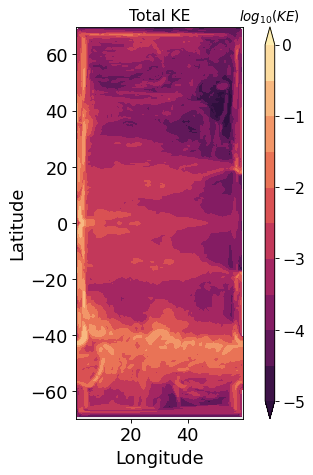

In [260]:
fig = plt.figure(figsize=(4, 7), dpi=80, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_title('Total KE',fontsize=14)
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 

plotted =ax1.contourf(xh,yh,np.log10(KE_tot_planview),levels=np.linspace(-5.,0,11),cmap=cmocean.cm.matter_r,extend='both')
ax1.set_aspect('equal', 'box')

ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax2.tick_params(labelsize=14)
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=14);
ax2.set_title('$log_{10}(KE)$')


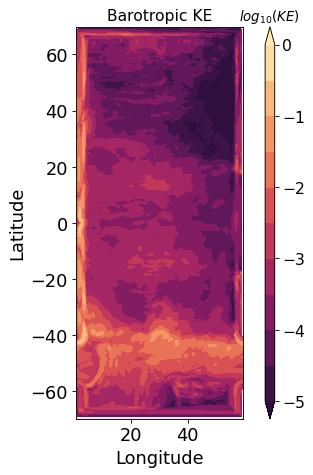

In [261]:
fig = plt.figure(figsize=(4, 7), dpi=80, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_title('Barotropic KE',fontsize=14)
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 

plotted =ax1.contourf(xh,yh,np.log10(KE_BT_tot_planview),levels=np.linspace(-5.,0,11),cmap=cmocean.cm.matter_r,extend='both')
ax1.set_aspect('equal', 'box')

ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax2.tick_params(labelsize=14)
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=14);
ax2.set_title('$log_{10}(KE)$')
#
plt.show()

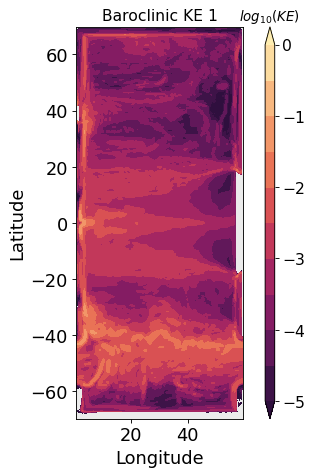

In [262]:
fig = plt.figure(figsize=(4, 7), dpi=80, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_title('Baroclinic KE 1',fontsize=14) #METHOD 1
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 

plotted =ax1.contourf(xh,yh,np.log10(KE_BC_tot_1_planview),levels=np.linspace(-5.,0,11),cmap=cmocean.cm.matter_r,extend='both')
ax1.set_aspect('equal', 'box')

ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax2.tick_params(labelsize=14)
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=14);
ax2.set_title('$log_{10}(KE)$')
#
plt.show()

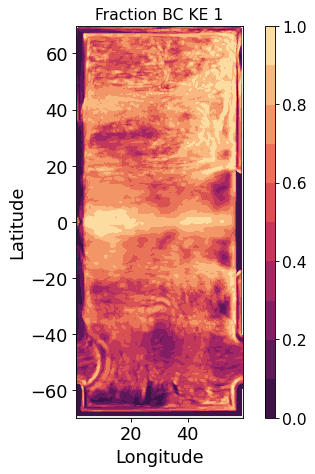

In [263]:
fig = plt.figure(figsize=(4, 7), dpi=80, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_title('Fraction BC KE 1',fontsize=14)
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 


plotted =ax1.contourf(xh,yh,fraction_BC,levels=np.linspace(0.,1.,11),cmap=cmocean.cm.matter_r)
ax1.set_aspect('equal', 'box')

ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax2.tick_params(labelsize=14)
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=14);

#
plt.show()

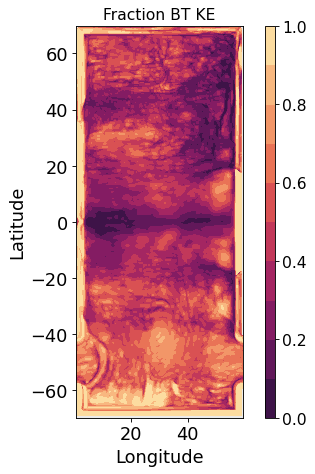

In [264]:
fig = plt.figure(figsize=(4, 7), dpi=80, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_title('Fraction BT KE',fontsize=14)
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 

plotted =ax1.contourf(xh,yh,fraction_BT,levels=np.linspace(0.,1.,11),cmap=cmocean.cm.matter_r)
ax1.set_aspect('equal', 'box')

ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax2.tick_params(labelsize=14)
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=14);

#
plt.show()

Text(0.5, 1.0, '1/32$^\\circ$ KE fractions')

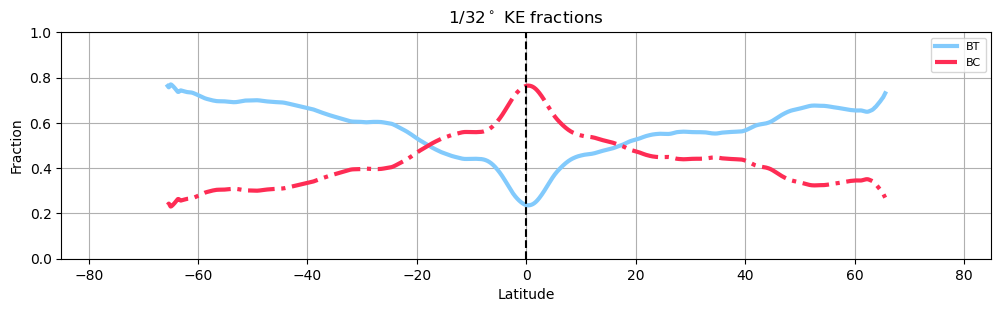

In [7]:
#For the convolution window use N=240 for 1/32 deg.; N=120 for 1/16deg.; N=60 for 1/8deg.; and N=30 for 1/4deg.
window=240

plt.figure(figsize=(12, 3), dpi= 100, facecolor='w', edgecolor='k')
#plt.plot(yh,np.nanmean(fraction_BT,axis=1),'-',c='#82cafc',linewidth=3)
plt.plot(yh,np.convolve(np.nanmean(fraction_BT,axis=1), np.ones((window,))/window, mode='same'),'-',c='#82cafc',linewidth=3)
plt.grid()
plt.plot(yh,np.convolve(np.nanmean(fraction_BC,axis=1), np.ones((window,))/window, mode='same'),'-.',c='#fe2c54',linewidth=3)

plt.legend(['BT','BC'],loc='upper right',fontsize=8)
plt.plot([0, 0],[0, 1],'--',color=[0,0,0])
plt.xlim(-85, 85)
plt.ylim(0,1);
plt.xlabel('Latitude')
plt.ylabel('Fraction')
plt.title('1/32$^\circ$ KE fractions')

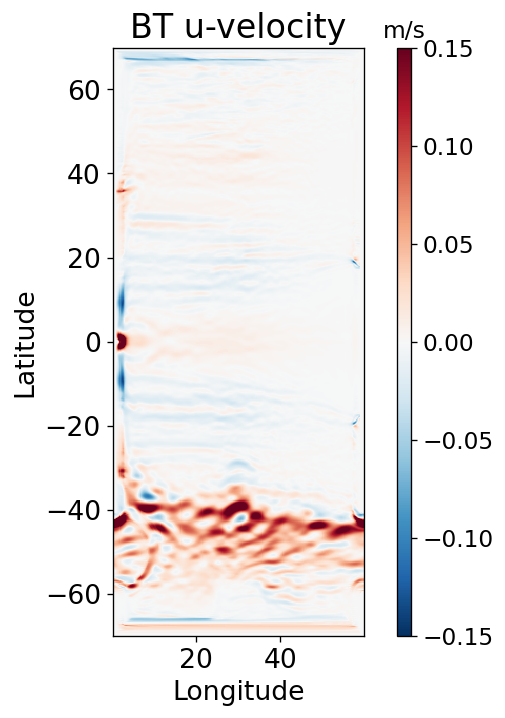

In [7]:
#Plotting BT velocities
fig = plt.figure(figsize=(4, 7), dpi= 120, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_title('BT u-velocity',fontsize=20)
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 
ax2.tick_params(labelsize=14)
ax2.set_title('m/s',fontsize=14)

plotted =ax1.pcolor(xh,yh,np.nanmean(BT_u[:,0,:,:],axis=0),cmap='RdBu_r',vmin=-.15,vmax=.15)
ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=14);

#
plt.show()
#fig.savefig('topography.png')

In [ ]:
#Plotting BT velocities
fig = plt.figure(figsize=(4, 7), dpi= 120, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_title('BT v-velocity',fontsize=20)
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 
ax2.tick_params(labelsize=14)
ax2.set_title('m/s',fontsize=14)

plotted =ax1.pcolor(xh,yh,np.nanmean(BT_v[:,0,:,:],axis=0),cmap='RdBu_r',vmin=-.15,vmax=.15)
ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=14);
#
plt.show()
#fig.savefig('topography.png')